<a href="https://colab.research.google.com/github/Ashishxyz/HealthVision/blob/main/BestModelPerformanceGraphs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip uninstall typeguard inflect tensorflow-addons -y
!pip install tensorflow-addons==0.23.0 typeguard==2.13.3 inflect==5.3.0

!pip install tensorflow==2.15.0

import tensorflow as tf
import tensorflow_addons as tfa

print("TensorFlow version:", tf.__version__)
print("TensorFlow Addons version:", tfa.__version__)

!pip install lime

Found existing installation: typeguard 4.3.0
Uninstalling typeguard-4.3.0:
  Successfully uninstalled typeguard-4.3.0
Found existing installation: inflect 7.4.0
Uninstalling inflect-7.4.0:
  Successfully uninstalled inflect-7.4.0
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 56.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 45.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 88.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.0/442.0 kB 23.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 5.2 MB/s eta 0:00:00
  Attempting uninstall: wrapt
    Found existing installation: wrapt 1.16.0
    Uninstalling wrapt-1.16.0:
      Successfully uninstalled wrapt-1.16.0
  Attempting uninstall: ml-dtypes
    Found existing installation: ml

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


TensorFlow version: 2.15.0
TensorFlow Addons version: 0.23.0
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 4.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=b2fed3ad94970d3e21eabe338da138803dd33269f35d2f4a691f04aa677d2f32
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime


In [ ]:
import numpy as np
import pandas as pd
import cv2
import os
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import DenseNet121
import tensorflow_addons as tfa
import tensorflow as tf
from tqdm import notebook
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from sklearn.metrics import confusion_matrix
import seaborn as sns
import lime
from lime import lime_image
from skimage.segmentation import mark_boundaries

In [ ]:
IMG_SIZE = 256
BATCH_SIZE = 32

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

!kaggle competitions download -c aptos2019-blindness-detection

100% 9.51G/9.51G [01:56<00:00, 116MB/s]
100% 9.51G/9.51G [01:56<00:00, 87.5MB/s]


In [ ]:
import zipfile
zip_ref = zipfile.ZipFile('/content/aptos2019-blindness-detection.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [ ]:
df = pd.read_csv('/content/train.csv')
df.head()

,id_code,diagnosis
0,000c1434d8d7,2
1,001639a390f0,4
2,0024cdab0c1e,1
3,002c21358ce6,0
4,005b95c28852,0


In [ ]:
x_train, x_val, y_train, y_val = train_test_split(df['id_code'], df['diagnosis'], test_size=0.15, stratify=df['diagnosis'], random_state=100)  # Splitting the dataset
x_train = x_train.reset_index(drop=True)  # Reindexing the training set
x_val = x_val.reset_index(drop=True)      # Reindexing the validation set
y_train = y_train.reset_index(drop=True)  # Reindexing the training labels
y_val = y_val.reset_index(drop=True)      # Reindexing the validation labels

In [ ]:
def crop_image(img):

    # Determine the height and width of the image
    h = img.shape[0]
    w = img.shape[1]

    # Calculate the center pixel
    Ch = h // 2
    Cw = w // 2

    # Find the first non-black pixel directly above the center pixel
    P = 0
    for i in range(Ch):
        if not(all(img[i][Cw] == 0)):
            P = i
            break

    # Calculate the radius of the retina
    R = Ch - P

    # Define the cropping boundaries
    X1 = Ch - R
    X2 = Ch + R
    Y1 = Cw - R
    Y2 = Cw + R

    img_cropped = []
    # Crop the image
    for i in range(3):
        img_cropped.append(img[X1:X2, Y1:Y2, i])

    img_cropped = np.dstack(img_cropped)

    return img_cropped

In [ ]:
def crop_image_from_gray(img, tol=7):
    # For grayscale images
    if img.ndim == 2:
        mask = img > tol
        return img[np.ix_(mask.any(axis=1), mask.any(axis=0))]  # Create a boolean array for rows and columns

    # For RGB images
    elif img.ndim == 3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)  # Convert RGB image to grayscale
        mask = gray_img > tol  # Create a boolean mask

        check_shape = img[:, :, 0][np.ix_(mask.any(axis=1), mask.any(axis=0))].shape[0]
        if check_shape == 0:  # If the whole image is too dark and cropped
            return img  # Return the original image
        else:
            img1 = img[:, :, 0][np.ix_(mask.any(axis=1), mask.any(axis=0))]  # Apply mask to channel 0
            img2 = img[:, :, 1][np.ix_(mask.any(axis=1), mask.any(axis=0))]  # Apply mask to channel 1
            img3 = img[:, :, 2][np.ix_(mask.any(axis=1), mask.any(axis=0))]  # Apply mask to channel 2
            img = np.stack([img1, img2, img3], axis=-1)  # Stack channels back together
        return img

In [ ]:
IMG_SIZE = 256

def preprocess(image_path):
    image = cv2.imread(image_path)  # Read the image
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR image to RGB
    image = crop_image_from_gray(image)  # Crop the image to remove black areas
    image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))  # Resize the image to uniform size
    image = cv2.addWeighted(image, 4, cv2.GaussianBlur(image, (0, 0), 10), -4, 128)  # Blend with Gaussian blur
    return image


In [ ]:
x_train = x_train.apply(lambda i:'/content/train_images/' + i + ".png")
x_val = x_val.apply(lambda i: '/content/train_images/' + i + ".png")

In [ ]:
train_images = np.empty((len(x_train), IMG_SIZE, IMG_SIZE, 3), dtype='uint8')  # Create an empty numpy array

# Preprocess each image and store it in the array
for i, path in enumerate(notebook.tqdm(x_train)):
    train_images[i] = preprocess(path)

# One-hot encode the target variable
y_train = pd.get_dummies(y_train).values

  0%|          | 0/3112 [00:00<?, ?it/s]

In [ ]:
val_images = np.empty((len(x_val),IMG_SIZE,IMG_SIZE,3), dtype='uint8')
for i,path in enumerate(notebook.tqdm(x_val)):
    val_images[i] = preprocess(path)

  0%|          | 0/550 [00:00<?, ?it/s]

In [ ]:
import pandas as pd

# Assuming y_train and y_val are already defined
print("Initial y_train shape:", y_train.shape)  # Should print (3112, 5)
print("Initial y_val shape:", y_val.shape)      # Should print (550,)

# y_train is already one-hot encoded; you can use it directly.
# For y_val, check if it needs to be converted to one-hot encoding.
if len(y_val.shape) == 1:  # y_val is one-dimensional
    y_val = pd.get_dummies(y_val).values  # Convert to one-hot encoding
    print("Updated y_val shape:", y_val.shape)  # Should print (550, number_of_classes)

# If y_val is already one-hot encoded, you can use it as is.
else:
    print("y_val is already in the correct shape:", y_val.shape)

Initial y_train shape: (3112, 5)
Initial y_val shape: (550,)
Updated y_val shape: (550, 5)


18/18 [==============================] - 139s 8s/step


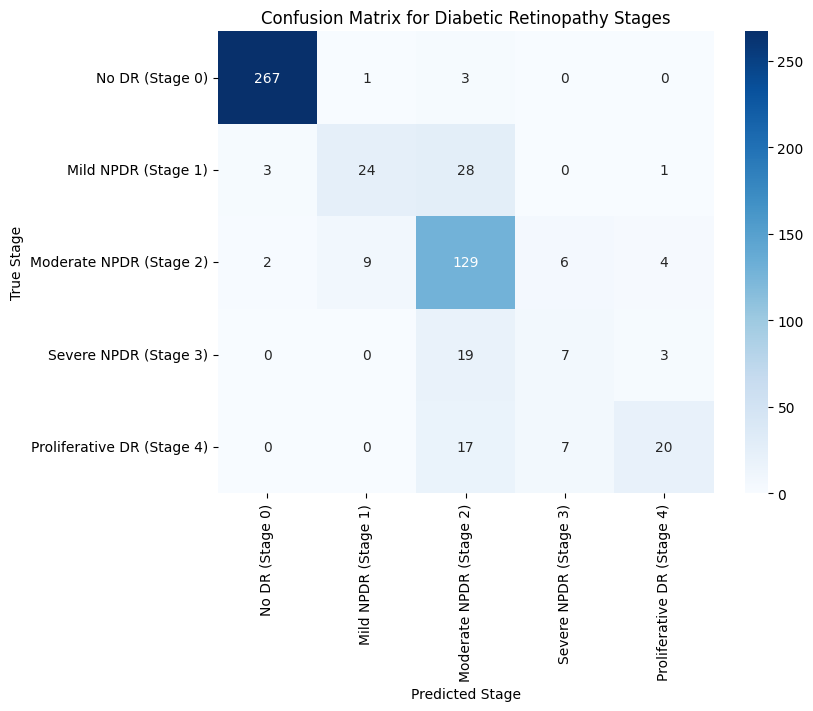

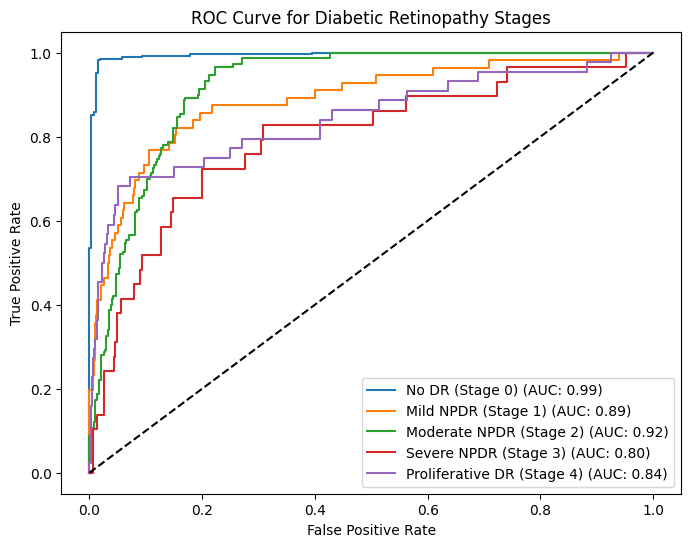

Accuracy: 0.8127
Precision (weighted): 0.8106
Recall (weighted): 0.8127
F1 Score (weighted): 0.8017


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
from tensorflow.keras.models import load_model

# Load your saved model
model = load_model('0.89_Dense121_.h5')

# Class labels as per Diabetic Retinopathy stages
class_labels = [
    'No DR (Stage 0)',
    'Mild NPDR (Stage 1)',
    'Moderate NPDR (Stage 2)',
    'Severe NPDR (Stage 3)',
    'Proliferative DR (Stage 4)'
]

# Assuming val_images and y_val are already preprocessed as in your previous code
# Predict probabilities for validation images
y_pred_prob = model.predict(val_images)
# Convert probabilities to predicted classes
y_pred = np.argmax(y_pred_prob, axis=1)

# Convert one-hot encoded y_val back to labels
y_true = np.argmax(y_val, axis=1)

### 1. Confusion Matrix ###
conf_matrix = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix for Diabetic Retinopathy Stages')
plt.xlabel('Predicted Stage')
plt.ylabel('True Stage')
plt.show()

### 2. ROC Curve ###
plt.figure(figsize=(8, 6))
for i in range(len(class_labels)):
    fpr, tpr, _ = roc_curve(y_val[:, i], y_pred_prob[:, i])
    plt.plot(fpr, tpr, label=f'{class_labels[i]} (AUC: {roc_auc_score(y_val[:, i], y_pred_prob[:, i]):.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.title('ROC Curve for Diabetic Retinopathy Stages')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()

### 3. Accuracy ###
accuracy = accuracy_score(y_true, y_pred)
print(f'Accuracy: {accuracy:.4f}')

### 4. Precision ###
precision = precision_score(y_true, y_pred, average='weighted')
print(f'Precision (weighted): {precision:.4f}')

### 5. Recall ###
recall = recall_score(y_true, y_pred, average='weighted')
print(f'Recall (weighted): {recall:.4f}')

### 6. F1 Score ###
f1 = f1_score(y_true, y_pred, average='weighted')
print(f'F1 Score (weighted): {f1:.4f}')